<a href="https://colab.research.google.com/github/vimarsh6739/CS6910_2020_Assignments/blob/main/Project/CS6910_Self_Calibrated_Convolutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
! git clone https://github.com/MCG-NKU/SCNet.git # clone paper models for pretrained weights

In [ ]:
! git clone https://github.com/tanjimin/grad-cam-pytorch-light.git grad_cam_pytorch

## Download datasets

In [5]:
import os
import torch
from torchvision.datasets.utils import download_url
import tarfile

In [6]:
imagenette_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette2-160.tgz"
imagewoof_url = "https://s3.amazonaws.com/fast-ai-imageclas/imagewoof2-160.tgz"

# Download dataset tars
download_url(imagenette_url,'.')
download_url(imagewoof_url, '.')

# Extract imagewoof
with tarfile.open('./imagewoof2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

# Extract imagenette
with tarfile.open('./imagenette2-160.tgz', 'r:gz') as tar:
    tar.extractall(path='./data')

Using downloaded and verified file: ./imagenette2-160.tgz
Using downloaded and verified file: ./imagewoof2-160.tgz
Using downloaded and verified file: ./imagewang-160.tgz


In [ ]:
# Look into the data directory contents
data_dirs = ['./data/imagewoof2-160','./data/imagenette2-160']
for dset in data_dirs:
  print('|=====>',dset)
  print(os.listdir(dset))
  classes = os.listdir(dset + "/train")
  print(classes)

## Load data and train models

Import libraries

In [8]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms as T
from torchvision import models
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
import csv
from SCNet import scnet

Get dataloader

In [9]:
def get_loaders(root_dir, transform = {'train':None,'val':None}, batch_size=32, num_workers=2):
  # Get training data
  train_dir = os.path.join(root_dir,'train')
  trainset = ImageFolder(root=train_dir, transform=transform['train'])
  print(f'Length of training dataset = {len(trainset)}')
  trainloader = torch.utils.data.DataLoader(trainset, 
                           batch_size=batch_size, 
                           shuffle=True, 
                           num_workers=num_workers,
                           drop_last=True)
  # Get validation data
  val_dir = os.path.join(root_dir,'val')
  valset = ImageFolder(root=val_dir, transform=transform['val'])
  print(f'Length of validation dataset = {len(valset)}')
  valloader = torch.utils.data.DataLoader(valset, 
                         batch_size=batch_size, 
                         shuffle=False, 
                         num_workers=num_workers)
  
  return trainloader, valloader, len(trainset), len(valset)

In [10]:
## Recommended transform for Imagenet images
IMAGE_SIZE=224

TRANSFORMS = {
    'train': T.Compose([
        T.RandomResizedCrop(IMAGE_SIZE),
        T.RandomHorizontalFlip(),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': T.Compose([
        T.Resize(256),
        T.CenterCrop(IMAGE_SIZE),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# trainloader,valloader,trainlen, vallen = get_loaders('./data/imagewang-160', transform=TRANSFORMS)

Visualize a batch

In [11]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize=(12, 12))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(images[:64], nrow=8).permute(1, 2, 0))
    break

# show_batch(trainloader)

Train model

In [12]:
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [13]:
def train_model(model, data_dir, num_epochs, optimizer, criterion,save_path=None):
  
  train_dl, val_dl, train_len, val_len = get_loaders(data_dir, transform=TRANSFORMS)
  tr_loss = []
  val_loss = []
  tr_acc = []
  val_acc = []
  best_val_acc = 0.0
  since = time.time()
  for epoch in range(num_epochs):
    # Train data
    tr_epoch_loss = 0.0
    tr_epoch_acc = 0.0
    for data in tqdm(train_dl):
      inputs, labels = data
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs,labels)
      loss.backward()
      optimizer.step()

      tr_epoch_loss += loss.item()
      _, predicted = torch.max(outputs.data,1)
      tr_epoch_acc += (predicted == labels).sum().item()
    
    tr_epoch_loss /= len(train_dl)
    tr_epoch_acc = 100 * tr_epoch_acc / train_len
    tr_loss.append(tr_epoch_loss)
    tr_acc.append(tr_epoch_acc)

    # Validate data
    model.eval() # Set model in evaluation mode
    val_epoch_loss = 0.0
    val_epoch_acc = 0.0
    with torch.no_grad(): # disable gradient computation
      for data in tqdm(val_dl):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        val_epoch_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        val_epoch_acc += (predicted == labels).sum().item()
    
    val_epoch_loss /= len(val_dl)
    val_epoch_acc = 100 * val_epoch_acc / val_len
    val_loss.append(val_epoch_loss)
    val_acc.append(val_epoch_acc)

    # Print Statistics
    print("\nEpoch: [{}/{} ({:.0f}%)]\n train Loss: {:.6f} Acc: {:.3f}\n Val Loss: {:.6f} Acc: {:.3f}".
              format(epoch+1, num_epochs, 
                     100. * (epoch+1) / num_epochs, 
                     tr_epoch_loss,
                     tr_epoch_acc,
                     val_epoch_loss,
                     val_epoch_acc))

    # Overwrite best model 
    model.train()  #Set model in training mode
    if(val_acc[-1] > best_val_acc ):
      best_val_acc = val_epoch_acc
      if(save_path != None):
        print('!Updating best model to current model!')
        torch.save({'epoch':epoch+1,
                  'tr_loss':tr_epoch_loss,
                  'model_state_dict':model.state_dict(),
                  'optimizer_state_dict':optimizer.state_dict()},save_path)
    print('-' * 10)

  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
  print('Best val Acc: {:4f}'.format(best_val_acc))

  return tr_loss, tr_acc, val_loss, val_acc

## Start transfer learning and benchmark

In [14]:
def get_model(data_dir, model_type='resnet50'):
  if model_type == 'scnet50':
    model = scnet.scnet50(pretrained=True)
  elif model_type == 'scnet101':
    model = scnet.scnet101(pretrained=True)
  elif model_type == 'resnet101':
    model = models.resnet101(pretrained=True)
  else:
    model = models.resnet50(pretrained=True)

  # Freeze all convolution layers
  for param in model.parameters():
    param.requires_grad = False

  # Redefine final layer
  num_ftrs = model.fc.in_features
  model.fc = nn.Linear(num_ftrs, len(os.path.join(data_dir,'train')))
  model = model.to(device)

  criterion = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.fc.parameters(), lr=0.001, momentum=0.9)
  return model, optimizer, criterion

Train both resnet and scnet models 

In [15]:
os.makedirs('./drive/MyDrive/CS6910_Project/models',exist_ok=True)

model_types = ['resnet50', 'scnet50', 'resnet101', 'scnet101']
datasets = {'imagewoof': './data/imagewoof2-160' , 'imagenette':'./data/imagenette2-160'}

for dset in datasets.keys():
  d_path = datasets[dset]
  print('Training Models for ', dset)
  print('-'*20)
  for model_type in model_types:
    print('Training ', model_type)
    print('-'*15)

    model_path = './drive/MyDrive/CS6910_Project/models/'+model_type+'_'+dset+'.pth'

    model, optimizer, criterion = get_model(data_dir=d_path, model_type=model_type)
    tr_loss, tr_acc, val_loss, val_acc = train_model(model = model,
                        data_dir = d_path,
                        num_epochs=15,
                        optimizer=optimizer,
                        criterion=criterion,
                        save_path=model_path)
    
    csv_path = './drive/MyDrive/CS6910_Project/models'+model_type+'_'+dset+'.csv'
    with open(csv_path, 'w') as f:
      writer = csv.writer(f)
      writer.writerows(zip(tr_loss, tr_acc, val_loss, val_acc))
    print('Saved loss values to ', os.path.basename(csv_path))

Training Models for  imagewoof
--------------------
Training  resnet50
---------------


  0%|          | 0/282 [00:00<?, ?it/s]

Length of training dataset = 9025
Length of validation dataset = 3929


100%|██████████| 123/123 [00:13<00:00,  8.94it/s]



Epoch: [1/15 (7%)]
 train Loss: 1.113176 Acc: 71.269
 Val Loss: 0.364078 Acc: 91.525
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.73it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.649580 Acc: 80.975
 Val Loss: 0.286061 Acc: 92.390
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.59it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.597633 Acc: 81.152
 Val Loss: 0.247341 Acc: 93.052
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [4/15 (27%)]
 train Loss: 0.568215 Acc: 81.717
 Val Loss: 0.236607 Acc: 93.026
----------


100%|██████████| 123/123 [00:14<00:00,  8.66it/s]



Epoch: [5/15 (33%)]
 train Loss: 0.554659 Acc: 81.684
 Val Loss: 0.230582 Acc: 93.383
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.67it/s]



Epoch: [6/15 (40%)]
 train Loss: 0.560517 Acc: 82.006
 Val Loss: 0.219532 Acc: 93.561
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.537098 Acc: 82.094
 Val Loss: 0.211600 Acc: 93.433
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [8/15 (53%)]
 train Loss: 0.537858 Acc: 82.260
 Val Loss: 0.216518 Acc: 93.179
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [9/15 (60%)]
 train Loss: 0.516837 Acc: 82.526
 Val Loss: 0.206610 Acc: 93.459
----------


100%|██████████| 123/123 [00:14<00:00,  8.71it/s]



Epoch: [10/15 (67%)]
 train Loss: 0.512927 Acc: 82.748
 Val Loss: 0.206263 Acc: 93.688
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.517352 Acc: 82.582
 Val Loss: 0.205862 Acc: 93.408
----------


100%|██████████| 123/123 [00:14<00:00,  8.59it/s]



Epoch: [12/15 (80%)]
 train Loss: 0.508982 Acc: 83.147
 Val Loss: 0.203564 Acc: 93.993
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.505592 Acc: 82.970
 Val Loss: 0.209106 Acc: 93.255
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.520619 Acc: 82.116
 Val Loss: 0.209651 Acc: 93.230
----------


100%|██████████| 123/123 [00:14<00:00,  8.69it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.490401 Acc: 83.612
 Val Loss: 0.200739 Acc: 93.255
----------
Training complete in 11m 52s
Best val Acc: 93.993383
Saved loss values to  modelsresnet50_imagewoof.csv
Training  scnet50
---------------


Downloading: "https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet50-dc6a7e87.pth" to /root/.cache/torch/hub/checkpoints/scnet50-dc6a7e87.pth


  0%|          | 0/282 [00:00<?, ?it/s]

Length of training dataset = 9025
Length of validation dataset = 3929


100%|██████████| 123/123 [00:15<00:00,  7.92it/s]



Epoch: [1/15 (7%)]
 train Loss: 1.372436 Acc: 68.909
 Val Loss: 0.486386 Acc: 91.474
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.87it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.788517 Acc: 78.116
 Val Loss: 0.355460 Acc: 91.906
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.95it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.709719 Acc: 78.571
 Val Loss: 0.300430 Acc: 92.543
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.91it/s]



Epoch: [4/15 (27%)]
 train Loss: 0.655993 Acc: 79.424
 Val Loss: 0.278035 Acc: 92.644
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [5/15 (33%)]
 train Loss: 0.644845 Acc: 79.158
 Val Loss: 0.272662 Acc: 92.543
----------


100%|██████████| 123/123 [00:15<00:00,  7.91it/s]



Epoch: [6/15 (40%)]
 train Loss: 0.633261 Acc: 79.834
 Val Loss: 0.258060 Acc: 92.695
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.622675 Acc: 79.767
 Val Loss: 0.253702 Acc: 92.568
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [8/15 (53%)]
 train Loss: 0.613401 Acc: 79.845
 Val Loss: 0.254447 Acc: 92.619
----------


100%|██████████| 123/123 [00:15<00:00,  7.93it/s]



Epoch: [9/15 (60%)]
 train Loss: 0.612019 Acc: 79.778
 Val Loss: 0.238480 Acc: 92.950
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.95it/s]



Epoch: [10/15 (67%)]
 train Loss: 0.594949 Acc: 80.321
 Val Loss: 0.235489 Acc: 93.103
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.608290 Acc: 79.778
 Val Loss: 0.238599 Acc: 92.874
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.607576 Acc: 80.011
 Val Loss: 0.237466 Acc: 92.212
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.592757 Acc: 80.288
 Val Loss: 0.233652 Acc: 92.746
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.577438 Acc: 80.809
 Val Loss: 0.232722 Acc: 92.975
----------


100%|██████████| 123/123 [00:15<00:00,  7.86it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.561092 Acc: 81.030
 Val Loss: 0.231360 Acc: 92.492
----------
Training complete in 12m 55s
Best val Acc: 93.102571
Saved loss values to  modelsscnet50_imagewoof.csv
Training  resnet101
---------------


Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


  0%|          | 0/282 [00:00<?, ?it/s]

Length of training dataset = 9025
Length of validation dataset = 3929


100%|██████████| 123/123 [00:21<00:00,  5.71it/s]



Epoch: [1/15 (7%)]
 train Loss: 1.029188 Acc: 72.964
 Val Loss: 0.311396 Acc: 93.383
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.68it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.590901 Acc: 82.260
 Val Loss: 0.237343 Acc: 93.764
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.69it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.526476 Acc: 83.512
 Val Loss: 0.216506 Acc: 94.222
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.69it/s]



Epoch: [4/15 (27%)]
 train Loss: 0.494958 Acc: 83.989
 Val Loss: 0.198872 Acc: 94.299
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.70it/s]



Epoch: [5/15 (33%)]
 train Loss: 0.482196 Acc: 84.499
 Val Loss: 0.182239 Acc: 94.477
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.68it/s]



Epoch: [6/15 (40%)]
 train Loss: 0.495825 Acc: 83.657
 Val Loss: 0.180233 Acc: 94.655
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.468480 Acc: 84.609
 Val Loss: 0.177594 Acc: 94.324
----------


100%|██████████| 123/123 [00:21<00:00,  5.68it/s]



Epoch: [8/15 (53%)]
 train Loss: 0.458655 Acc: 84.820
 Val Loss: 0.169668 Acc: 94.731
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [9/15 (60%)]
 train Loss: 0.481439 Acc: 83.701
 Val Loss: 0.177130 Acc: 94.604
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [10/15 (67%)]
 train Loss: 0.471439 Acc: 84.244
 Val Loss: 0.170715 Acc: 94.477
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.458620 Acc: 84.831
 Val Loss: 0.180396 Acc: 94.095
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.466341 Acc: 84.055
 Val Loss: 0.168991 Acc: 94.452
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.466272 Acc: 84.343
 Val Loss: 0.169872 Acc: 94.553
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.461839 Acc: 84.532
 Val Loss: 0.170170 Acc: 94.502
----------


100%|██████████| 123/123 [00:21<00:00,  5.67it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.462633 Acc: 84.499
 Val Loss: 0.172357 Acc: 94.197
----------
Training complete in 18m 16s
Best val Acc: 94.731484
Saved loss values to  modelsresnet101_imagewoof.csv
Training  scnet101
---------------


Downloading: "https://backseason.oss-cn-beijing.aliyuncs.com/scnet/scnet101-44c5b751.pth" to /root/.cache/torch/hub/checkpoints/scnet101-44c5b751.pth


  0%|          | 0/282 [00:00<?, ?it/s]

Length of training dataset = 9025
Length of validation dataset = 3929


100%|██████████| 123/123 [00:23<00:00,  5.34it/s]



Epoch: [1/15 (7%)]
 train Loss: 1.318503 Acc: 70.859
 Val Loss: 0.425755 Acc: 93.306
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.25it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.736612 Acc: 79.413
 Val Loss: 0.303470 Acc: 93.433
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.24it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.663558 Acc: 80.044
 Val Loss: 0.266202 Acc: 93.637
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.21it/s]



Epoch: [4/15 (27%)]
 train Loss: 0.627984 Acc: 80.465
 Val Loss: 0.242007 Acc: 94.070
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [5/15 (33%)]
 train Loss: 0.621426 Acc: 80.166
 Val Loss: 0.225079 Acc: 93.942
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [6/15 (40%)]
 train Loss: 0.594353 Acc: 80.886
 Val Loss: 0.225375 Acc: 93.993
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.593550 Acc: 80.488
 Val Loss: 0.214032 Acc: 93.968
----------


100%|██████████| 123/123 [00:23<00:00,  5.20it/s]



Epoch: [8/15 (53%)]
 train Loss: 0.579227 Acc: 80.720
 Val Loss: 0.211554 Acc: 94.197
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.22it/s]



Epoch: [9/15 (60%)]
 train Loss: 0.567483 Acc: 80.853
 Val Loss: 0.203814 Acc: 94.477
!Updating best model to current model!


  0%|          | 0/282 [00:00<?, ?it/s]

----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [10/15 (67%)]
 train Loss: 0.561567 Acc: 81.540
 Val Loss: 0.196513 Acc: 94.477
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.560553 Acc: 81.374
 Val Loss: 0.196761 Acc: 94.452
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.566199 Acc: 80.953
 Val Loss: 0.196824 Acc: 94.248
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.563218 Acc: 81.341
 Val Loss: 0.194235 Acc: 94.172
----------


  0%|          | 0/282 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.544902 Acc: 81.640
 Val Loss: 0.197305 Acc: 94.044
----------


100%|██████████| 123/123 [00:23<00:00,  5.20it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.550419 Acc: 81.828
 Val Loss: 0.194544 Acc: 94.197
----------
Training complete in 20m 0s
Best val Acc: 94.476966
Saved loss values to  modelsscnet101_imagewoof.csv
Training Models for  imagenette
--------------------
Training  resnet50
---------------


  0%|          | 0/295 [00:00<?, ?it/s]

Length of training dataset = 9469
Length of validation dataset = 3925


100%|██████████| 123/123 [00:14<00:00,  8.24it/s]



Epoch: [1/15 (7%)]
 train Loss: 0.683342 Acc: 85.775
 Val Loss: 0.121077 Acc: 98.013
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.60it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.296514 Acc: 92.153
 Val Loss: 0.086171 Acc: 98.675
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [3/15 (20%)]
 train Loss: 0.252661 Acc: 92.914
 Val Loss: 0.070750 Acc: 98.675
----------


100%|██████████| 123/123 [00:14<00:00,  8.53it/s]



Epoch: [4/15 (27%)]
 train Loss: 0.259903 Acc: 92.291
 Val Loss: 0.062130 Acc: 98.803
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [5/15 (33%)]
 train Loss: 0.228902 Acc: 93.083
 Val Loss: 0.059425 Acc: 98.624
----------


100%|██████████| 123/123 [00:14<00:00,  8.51it/s]



Epoch: [6/15 (40%)]
 train Loss: 0.220322 Acc: 93.167
 Val Loss: 0.053605 Acc: 98.828
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.55it/s]



Epoch: [7/15 (47%)]
 train Loss: 0.218248 Acc: 92.977
 Val Loss: 0.051960 Acc: 98.854
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [8/15 (53%)]
 train Loss: 0.215314 Acc: 93.178
 Val Loss: 0.048319 Acc: 98.854
----------


100%|██████████| 123/123 [00:14<00:00,  8.54it/s]



Epoch: [9/15 (60%)]
 train Loss: 0.209772 Acc: 93.421
 Val Loss: 0.047873 Acc: 98.879
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:14<00:00,  8.44it/s]



Epoch: [10/15 (67%)]
 train Loss: 0.201455 Acc: 93.421
 Val Loss: 0.044363 Acc: 98.981
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.210838 Acc: 93.410
 Val Loss: 0.044904 Acc: 98.828
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.200366 Acc: 93.505
 Val Loss: 0.044105 Acc: 98.904
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.206037 Acc: 93.389
 Val Loss: 0.040925 Acc: 98.930
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.211992 Acc: 93.262
 Val Loss: 0.040856 Acc: 98.904
----------


100%|██████████| 123/123 [00:14<00:00,  8.46it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.203636 Acc: 93.019
 Val Loss: 0.043408 Acc: 98.726
----------
Training complete in 12m 30s
Best val Acc: 98.980892
Saved loss values to  modelsresnet50_imagenette.csv
Training  scnet50
---------------


  0%|          | 0/295 [00:00<?, ?it/s]

Length of training dataset = 9469
Length of validation dataset = 3925


100%|██████████| 123/123 [00:15<00:00,  7.82it/s]



Epoch: [1/15 (7%)]
 train Loss: 0.951952 Acc: 83.705
 Val Loss: 0.203090 Acc: 97.860
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.90it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.380282 Acc: 91.256
 Val Loss: 0.121004 Acc: 98.293
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.87it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.316892 Acc: 91.900
 Val Loss: 0.092269 Acc: 98.420
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:15<00:00,  7.90it/s]



Epoch: [4/15 (27%)]
 train Loss: 0.295359 Acc: 92.037
 Val Loss: 0.079160 Acc: 98.573
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [5/15 (33%)]
 train Loss: 0.282901 Acc: 91.752
 Val Loss: 0.075036 Acc: 98.573
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [6/15 (40%)]
 train Loss: 0.275031 Acc: 91.932
 Val Loss: 0.067926 Acc: 98.522
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.251263 Acc: 92.597
 Val Loss: 0.068303 Acc: 98.395
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [8/15 (53%)]
 train Loss: 0.260795 Acc: 92.005
 Val Loss: 0.062240 Acc: 98.522
----------


100%|██████████| 123/123 [00:15<00:00,  7.90it/s]



Epoch: [9/15 (60%)]
 train Loss: 0.261417 Acc: 91.678
 Val Loss: 0.057461 Acc: 98.675
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [10/15 (67%)]
 train Loss: 0.240813 Acc: 92.724
 Val Loss: 0.058797 Acc: 98.599
----------


100%|██████████| 123/123 [00:15<00:00,  7.85it/s]



Epoch: [11/15 (73%)]
 train Loss: 0.257964 Acc: 91.984
 Val Loss: 0.056854 Acc: 98.701
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.231940 Acc: 92.755
 Val Loss: 0.054419 Acc: 98.650
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.244152 Acc: 92.502
 Val Loss: 0.052763 Acc: 98.599
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.237006 Acc: 92.481
 Val Loss: 0.052446 Acc: 98.650
----------


100%|██████████| 123/123 [00:15<00:00,  7.81it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.240989 Acc: 92.322
 Val Loss: 0.052409 Acc: 98.752
!Updating best model to current model!
----------
Training complete in 13m 24s
Best val Acc: 98.751592
Saved loss values to  modelsscnet50_imagenette.csv
Training  resnet101
---------------


  0%|          | 0/295 [00:00<?, ?it/s]

Length of training dataset = 9469
Length of validation dataset = 3925


100%|██████████| 123/123 [00:21<00:00,  5.68it/s]



Epoch: [1/15 (7%)]
 train Loss: 0.608654 Acc: 87.422
 Val Loss: 0.092907 Acc: 98.497
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.66it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.249157 Acc: 93.357
 Val Loss: 0.062922 Acc: 98.828
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [3/15 (20%)]
 train Loss: 0.217628 Acc: 93.632
 Val Loss: 0.053002 Acc: 98.752
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [4/15 (27%)]
 train Loss: 0.208117 Acc: 93.431
 Val Loss: 0.046540 Acc: 98.752
----------


100%|██████████| 123/123 [00:21<00:00,  5.70it/s]



Epoch: [5/15 (33%)]
 train Loss: 0.192914 Acc: 94.086
 Val Loss: 0.043320 Acc: 98.879
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.67it/s]



Epoch: [6/15 (40%)]
 train Loss: 0.191722 Acc: 93.980
 Val Loss: 0.038626 Acc: 98.955
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [7/15 (47%)]
 train Loss: 0.190165 Acc: 93.959
 Val Loss: 0.038514 Acc: 98.879
----------


100%|██████████| 123/123 [00:21<00:00,  5.66it/s]



Epoch: [8/15 (53%)]
 train Loss: 0.170695 Acc: 94.751
 Val Loss: 0.035591 Acc: 98.981
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [9/15 (60%)]
 train Loss: 0.178392 Acc: 94.012
 Val Loss: 0.036376 Acc: 98.981
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [10/15 (67%)]
 train Loss: 0.177290 Acc: 94.213
 Val Loss: 0.034495 Acc: 98.904
----------


100%|██████████| 123/123 [00:21<00:00,  5.66it/s]



Epoch: [11/15 (73%)]
 train Loss: 0.174020 Acc: 94.413
 Val Loss: 0.033090 Acc: 99.032
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.69it/s]



Epoch: [12/15 (80%)]
 train Loss: 0.169321 Acc: 94.339
 Val Loss: 0.031708 Acc: 99.083
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [13/15 (87%)]
 train Loss: 0.176977 Acc: 94.192
 Val Loss: 0.032845 Acc: 99.006
----------


100%|██████████| 123/123 [00:21<00:00,  5.69it/s]



Epoch: [14/15 (93%)]
 train Loss: 0.169685 Acc: 94.361
 Val Loss: 0.030007 Acc: 99.108
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:21<00:00,  5.67it/s]



Epoch: [15/15 (100%)]
 train Loss: 0.170114 Acc: 94.487
 Val Loss: 0.034558 Acc: 98.930
----------
Training complete in 18m 57s
Best val Acc: 99.108280
Saved loss values to  modelsresnet101_imagenette.csv
Training  scnet101
---------------


  0%|          | 0/295 [00:00<?, ?it/s]

Length of training dataset = 9469
Length of validation dataset = 3925


100%|██████████| 123/123 [00:23<00:00,  5.21it/s]



Epoch: [1/15 (7%)]
 train Loss: 0.901333 Acc: 85.637
 Val Loss: 0.160229 Acc: 98.930
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.18it/s]



Epoch: [2/15 (13%)]
 train Loss: 0.356437 Acc: 91.847
 Val Loss: 0.103246 Acc: 99.083
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


100%|██████████| 123/123 [00:23<00:00,  5.18it/s]



Epoch: [3/15 (20%)]
 train Loss: 0.294786 Acc: 92.248
 Val Loss: 0.080650 Acc: 99.134
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [4/15 (27%)]
 train Loss: 0.283137 Acc: 92.259
 Val Loss: 0.063840 Acc: 99.108
----------


100%|██████████| 123/123 [00:23<00:00,  5.18it/s]



Epoch: [5/15 (33%)]
 train Loss: 0.268404 Acc: 92.227
 Val Loss: 0.055697 Acc: 99.236
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [6/15 (40%)]
 train Loss: 0.235677 Acc: 93.273
 Val Loss: 0.056323 Acc: 99.159
----------


100%|██████████| 123/123 [00:23<00:00,  5.18it/s]



Epoch: [7/15 (47%)]
 train Loss: 0.230610 Acc: 93.157
 Val Loss: 0.048378 Acc: 99.312
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [8/15 (53%)]
 train Loss: 0.242378 Acc: 92.586
 Val Loss: 0.045855 Acc: 99.210
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [9/15 (60%)]
 train Loss: 0.241010 Acc: 92.787
 Val Loss: 0.045536 Acc: 99.108
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [10/15 (67%)]
 train Loss: 0.236769 Acc: 92.629
 Val Loss: 0.045211 Acc: 99.236
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [11/15 (73%)]
 train Loss: 0.233848 Acc: 92.776
 Val Loss: 0.045143 Acc: 99.134
----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [12/15 (80%)]
 train Loss: 0.228601 Acc: 92.967
 Val Loss: 0.043583 Acc: 99.261
----------


100%|██████████| 123/123 [00:23<00:00,  5.22it/s]



Epoch: [13/15 (87%)]
 train Loss: 0.223771 Acc: 93.283
 Val Loss: 0.039533 Acc: 99.363
!Updating best model to current model!


  0%|          | 0/295 [00:00<?, ?it/s]

----------


  0%|          | 0/295 [00:00<?, ?it/s]


Epoch: [14/15 (93%)]
 train Loss: 0.231838 Acc: 92.724
 Val Loss: 0.038859 Acc: 99.185
----------


100%|██████████| 123/123 [00:23<00:00,  5.20it/s]


Epoch: [15/15 (100%)]
 train Loss: 0.233734 Acc: 92.417
 Val Loss: 0.040542 Acc: 99.210
----------
Training complete in 20m 42s
Best val Acc: 99.363057
Saved loss values to  modelsscnet101_imagenette.csv


## Visualize attentions using GRAD CAM

In [60]:
import torch 
from torchvision import transforms as T
import matplotlib.pyplot as plt
from PIL import Image
from grad_cam_pytorch.grad_cam import grad_cam

In [67]:
def visualize_gradCAM(img_paths, dsets, dset_dict, model_types, model_base_path, save_path=None):
  
  fig, axs = plt.subplots(len(model_types),len(dsets),figsize=(15,12))
  # fig.suptitle('Attention Map Visualization for all models')

  for j, dset in enumerate(dsets,0):
    for i, model_type in enumerate(model_types,0):
      model_path = model_base_path + '/' + model_type + '_' + dset + '.pth'
      
      # Load torch model
      if model_type == 'scnet50':
        model = scnet.scnet50(pretrained=False)
      elif model_type == 'scnet101':
        model = scnet.scnet101(pretrained=False)
      elif model_type == 'resnet101':
        model = models.resnet101(pretrained=False)
      else:
        model = models.resnet50(pretrained=False)
      
      model.eval()
      
      # Set the heatmap layer as the final conv layer
      if model_type == 'scnet50' or model_type=='scnet101':
        heatmap_layer = model.layer4[2].k1
      else:
        heatmap_layer = model.layer4[2].conv3

      # Select image to show
      img = Image.open(img_paths[j])
      input_tensor = T.Compose([T.Resize(256),
                                T.CenterCrop(224),
                                T.ToTensor(),
                                T.Normalize(mean = [0.485, 0.456, 0.406], 
                                            std = [0.229, 0.224, 0.225])])(img)

      final_img = grad_cam(model, input_tensor, heatmap_layer)
      axs[i,j].imshow(final_img)
      axs[i,j].tick_params(axis='both', which='both', length=0)
      axs[i,j].set_xticklabels([])
      axs[i,j].set_yticklabels([])
  
  # Label y axis
  for j, model_type in enumerate(model_types,0):
    axs[j,0].set_ylabel(model_type, fontsize=18)
  
  # Set no ticks
  plt.axis('off')
  if save_path!=None:
    plt.savefig(save_path, bbox_inches='tight')
  else:
    plt.show()

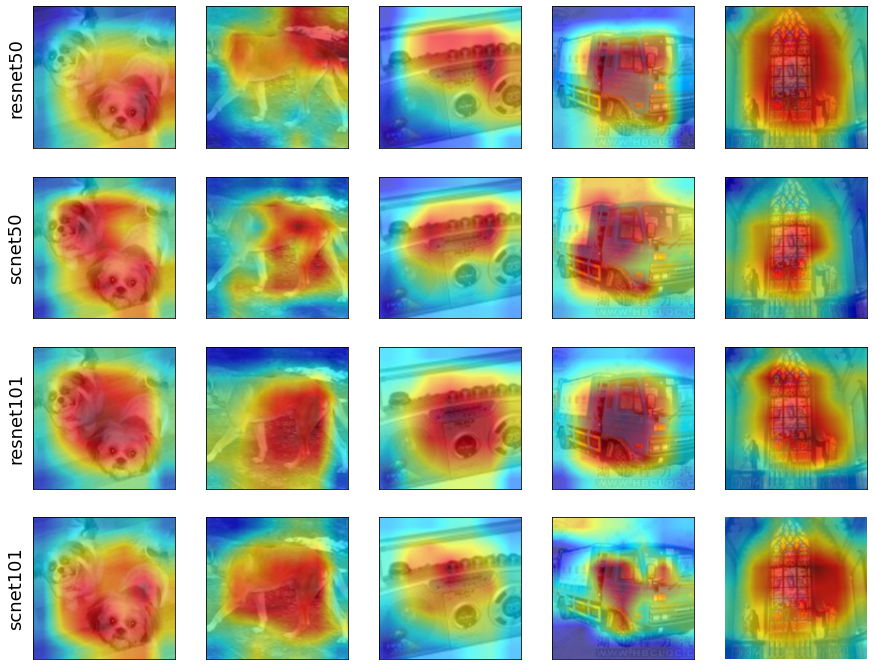

In [72]:
img_paths = ['./data/imagewoof2-160/train/n02086240/n02086240_2019.JPEG',
          './data/imagewoof2-160/train/n02115641/n02115641_10798.JPEG',
          './data/imagenette2-160/train/n02979186/n02979186_1043.JPEG',
          './data/imagenette2-160/train/n03417042/n03417042_12244.JPEG',
          './data/imagenette2-160/train/n03028079/n03028079_118756.JPEG']
dsets = ['imagewoof','imagewoof','imagenette','imagenette','imagenette']
datasets = {'imagewoof': './data/imagewoof2-160' , 'imagenette':'./data/imagenette2-160'}
model_types = ['resnet50', 'scnet50', 'resnet101', 'scnet101']

os.makedirs(os.path.join('./drive/MyDrive/CS6910_Project','images'),exist_ok=True)

visualize_gradCAM(img_paths, 
                  dsets, 
                  datasets,
                  model_types, 
                  model_base_path = './drive/MyDrive/CS6910_Project/models',
                  save_path='./drive/MyDrive/CS6910_Project/images/gradCAM_viz.png')